<p float="left">
  <img src=attachment:citrine_banner_2.png width="40%" height='10%' align="left" />
  <img src=attachment:nanoHUB_logo.png width="35%" height='10%' align="justify" /> 
</p>
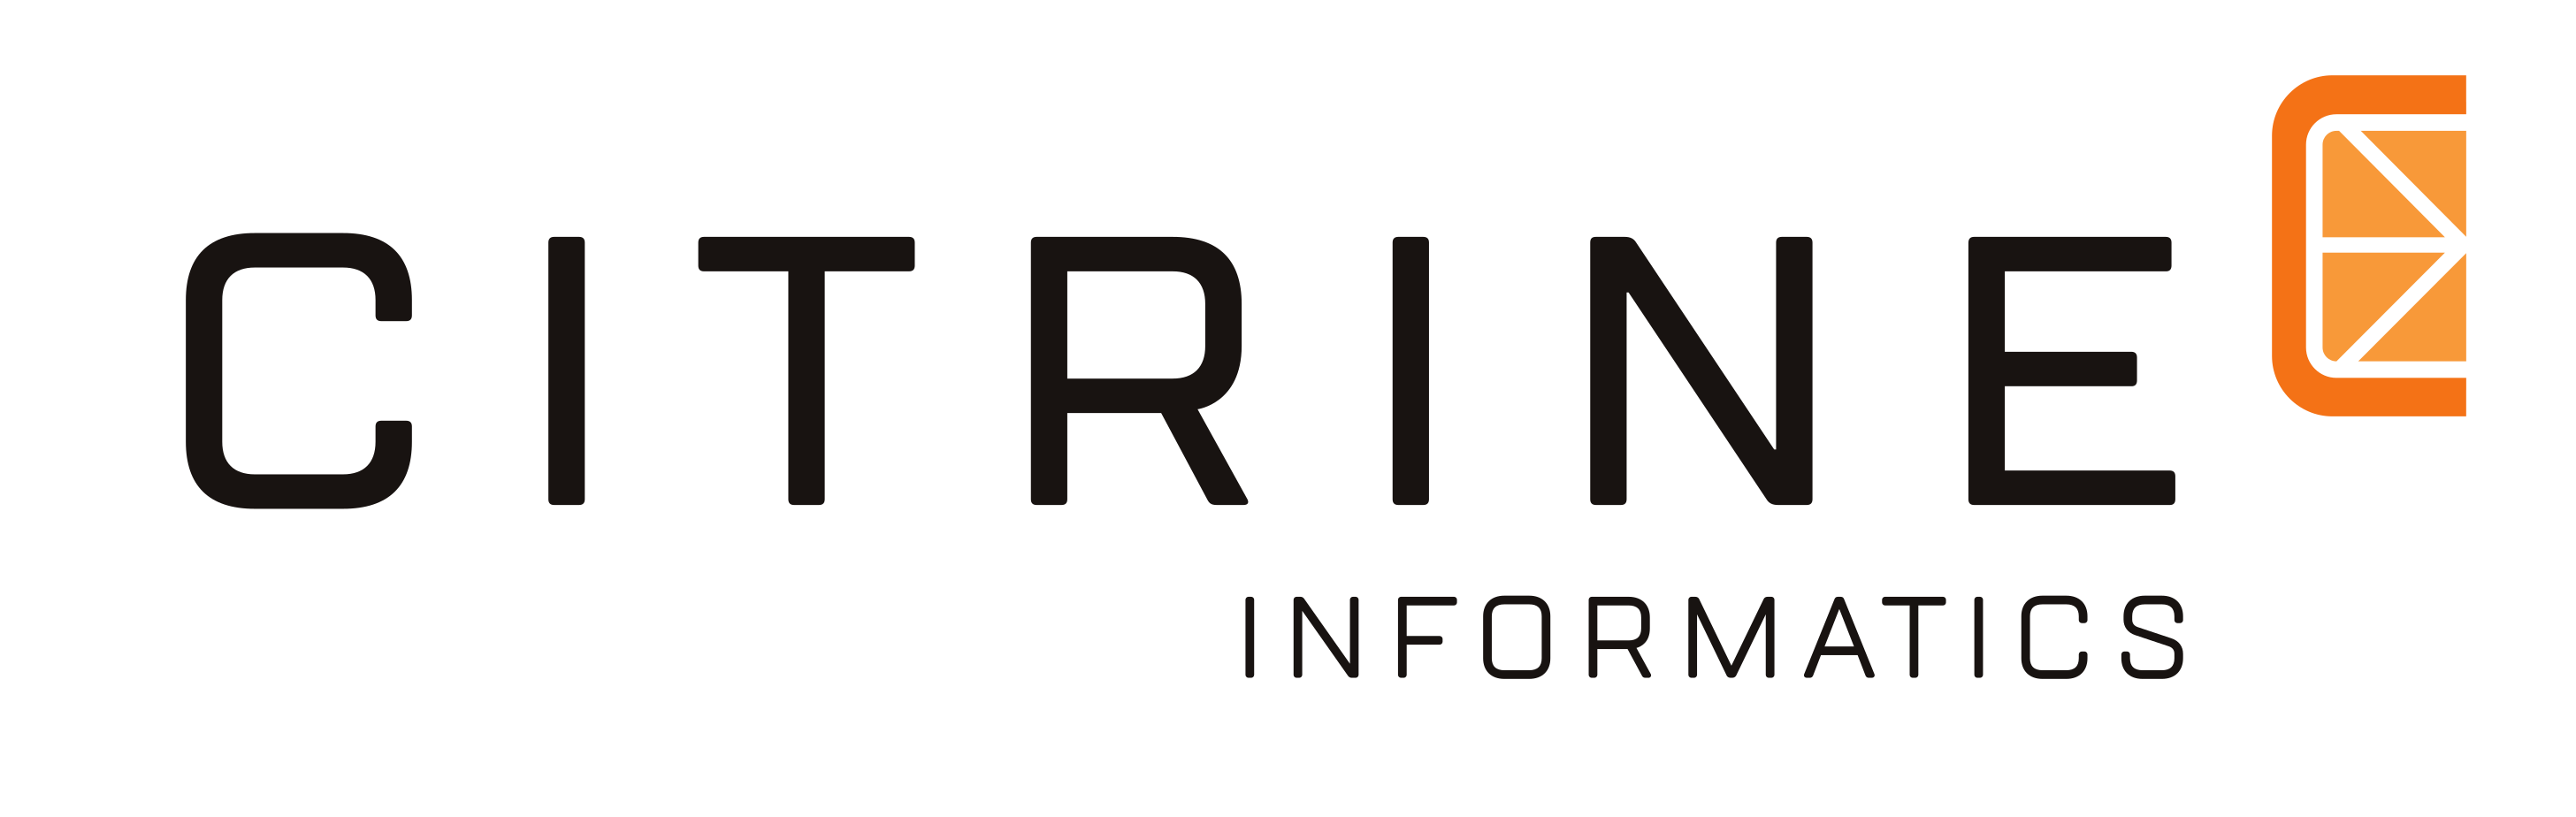
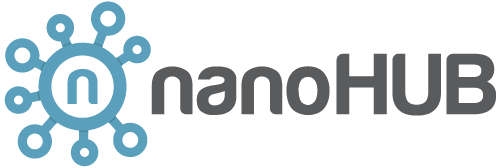

# Sequential Learning for Bulk Modulus from Citrination

### Authorship and credits

<b> Based on work published on: </b> [Julia Ling et al.](https://link.springer.com/article/10.1007/s40192-017-0098-z) <br> 
<b> Original notebooks from: </b> <i>Logan Ward</i>, Argonne National Laboratory, and <i>Max Hutchinson</i>, Citrine Informatics. Their Github implementation can be found [here](https://github.com/CitrineInformatics/lolo/blob/develop/python/examples/ling-immi-2017.ipynb).<br>
<b> nanoHUB tools by: </b>  <i>Juan Carlos Verduzco</i> and <i>Alejandro Strachan</i>, Materials Engineering, Purdue University <br>

## Overview

In this notebook, we'll introduce a workflow to optimize the number of experimental samples required to reach the maximum bulk modulus from composition.

**Outline:**

1. Querying a dataset<br>
2. Obtaining features/descriptors from Matminer <br>
3. Processing and Organizing Data <br>
4. Generating Model <br>
5. Active Learning <br>

<strike>Notes: This notebook uses tools from Citrination and requires an account with an API key. </strike>
⚠️🔴 Open Citrination has been decommissioned.

## Libraries

This notebook requires several libraries to be imported. They are separated in blocks depending on their usage.

In [ ]:
# PLOTTING (MATPLOTLIB)
%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib.animation as animation

# MATMINER
from matminer.featurizers.base import MultipleFeaturizer
from matminer.featurizers import composition as cf
from lolopy.learners import RandomForestRegressor

# PYTHON
import pandas as pd
import numpy as np
np.random.seed(1)
import os
from pymatgen import Composition
from scipy.stats import norm
from IPython.display import HTML

---
## 1. Querying a Database

Data is stored in a Pandas Dataframe.

In [ ]:
data = pd.read_csv('https://raw.github.itap.purdue.edu/StrachanGroup/nanoHUB_examples/master/citrinetools/mp_bulk_shear_v2.csv')
property_interest = 'Property: Bulk modulus (GPa)' # Property to be queried #Bulk modulus
data = data.dropna()
data = data[~data.formula.str.contains("Ne")]
display(data.head(n=10))

This is a utility function that will transform the <i>chemicalFormula</i> column into a Matminer composition object, which will be then used to extract features.

In [ ]:
def get_compostion(c): # Function to get compositions from chemical formula using pymatgen
    try:
        return Composition(c)
    except:
        return None

We will use the utility function to transform the <i>chemicalFormula</i> column, and we'll typecast relevant columns into numeric types.

In [ ]:
data['composition'] = data['formula'].apply(get_compostion)
data[property_interest] = pd.to_numeric(data[property_interest], errors='coerce')
data.reset_index(drop=True, inplace=True)

---

## 2. Obtaining features/descriptors from Matminer

Matminer offers a variety of featurizers that can be derived from composition. They can be found [here](https://hackingmaterials.lbl.gov/matminer/featurizer_summary.html).  
<br>
In this example, we will query the descriptors listed in the paper by [Ward et al.](https://www.nature.com/articles/npjcompumats201628).

In [ ]:
# Featurizer
f =  MultipleFeaturizer([cf.Stoichiometry(), cf.ElementProperty.from_preset("magpie"),
                         cf.ValenceOrbital(props=['avg']), cf.IonProperty(fast=True)])
# Inputs
X = np.array(f.featurize_many(data['composition']))
# Labels 
y = data[property_interest].values 

--- 
## 3. Processing and Organizing Data 

Active learning is the use of algorithms not for regression, but for the improvement of the input sample space that guides the 'experiments' required to get to such maximum values. Even if it does make predictions for a specific material, its main task is the selection of the most likely candidate to be in a global maxima. This is the approach introduced in the paper by Julia Ling et al.
<br>
<br>
We will select an initial set of 10 entries, and we'll make sure the highest value is not in it.

In [ ]:
np.random.seed(44)

in_train = np.zeros(len(data), dtype=np.bool)
in_train[np.random.choice(len(data), 10, replace=False)] = True
print('Picked {} training entries'.format(in_train.sum()))
assert not np.isclose(max(y), max(y[in_train]))

--- 
## 4. Generating Model

A random forest algorithm was used as a tool for regression. Its training data is the 10 examples we selected before. This information allows it to make predictions for all other compositions which we will then explore with different Information Acquisition Functions to choose which point to query next. 

In [ ]:
model = RandomForestRegressor()
model.fit(X[in_train], y[in_train])
y_pred, y_std = model.predict(X[~in_train], return_std=True)

---
## 5. Active Learning

Active learning is the use of algorithms not for regression, but for the improvement of the input sample space that guides the 'experiments' required to get to such maximum values. Even if it does make predictions for a specific material, its main task is the selection of the most likely candidate to be in a global maxima. Global optimization is based on the assumption that a model can perform better when it can "choose" which point to query next. This is the approach introduced in the paper by Julia Ling et al.


### 5.1 Uncertainty Estimates

The first step on active learning always comes from an approximation of the error in the prediction from the model. Relevant work on how to compute this estimates can be found in publications by [Efron](https://statistics.stanford.edu/sites/g/files/sbiybj6031/f/BIO%20262_0.pdf) and [Wager](https://jmlr.org/papers/volume15/wager14a/wager14a.pdf).

To compute an estimate, we need to understand how to compute some important quantities:

<b> Expected Value: </b> The mean of the predictions over all the decision trees representes the expected value for this particular model. The equation to compute this quantity is shown below:
<br>
<br>
$$ E[M(x)] = \frac{1}{N} \sum\limits_{J}^{n_T} T_J(x) $$
<br>

In this equation:

$E[M(x)] \rightarrow $ Expected value of the prediction of the model at point $x$
<br>
$ T_J(x) \rightarrow $ Prediction of tree index $J$ for point $x$
<br>
$n_T $ is the number of trees
<br>
<br>

<b> Variance: </b> For the calculation of the variance, we will compute the value of the <b>"Variance at point x due to training point i "</b>. For this model, we are following on the work from Ling et al, and using a combination of the jackknife-after-bootstrap and infinitesimal-jackknife estimates paired with a montecarlo sampling correction.

$$ \sigma^2_i(x) = Cov_j[n_{i,J}, T_J(x)]^2 + [\overline{T}_{-i}(x) - \overline{T}(x)]^2 - \frac{e\nu}{N_T} $$

In this equation:

$n_{i,J} \rightarrow $ Number of times point $i$ was used to train tree $J$
<br>
$\overline{T}_{-i}(x) \rightarrow $ Average of the prediction over the trees that were fit without using point $i$
<br>
$\overline{T}(x) \rightarrow $ Average of the prediction over all of the trees
<br>
$e$ is Euler's number and $\nu$ is the variance over all trees
<br>
<br>

<b> Uncertainty Estimate: </b> For the calculation of the estimate, we will add the contributions of each of the training points to the variance of our test point, together with an explicit bias model and a noise threshold.

$$ \sigma[M(x)] = \sqrt{ \sum\limits_{i=1}^S max[\sigma^2_i(x), \omega] + \widetilde{\sigma}^{ 2}(x)} $$

In this equation:

$\sigma^2_i(x) \rightarrow $ Variance at point x due to training point i
<br>
$\omega \rightarrow $ Noise threshold 
<br>
$ \widetilde{\sigma}^{ 2}(x) \rightarrow $ Explicit bias model
<br>
$S$ is the number of training points
<br>
<br>

The noise threshold ($\omega$) is defined as:
$$\omega = min_i \sigma^2 [M(x_i)]$$

### 5.2 Information Acquisition Functions

Information Acquisition Functions are based on different criterias on which point is more relevant for the model to query next. In this notebook we discuss MEI (Maximum Expected Improvement), MLI (Maximum Likelihood of Improvement) and MU (Maximum Uncertainty).

<b>MEI.</b> This approach takes the maximum value of the prediction of the model over the possible experiments to run.

<br>
$$ x^* = arg\_max \enspace E[M(x_i)]$$

where $x_i \rightarrow$ Set of possible experiments to run.

<br>

<b>MLI.</b> This approach tells us that we are expecting to query a region for which we see an improvement and sufficient uncertainty to have a high likelihood of getting a larger value.

$$ x^* = arg\_max \enspace \frac{E[M(x_i)] - E[M(x_{best})]}{\sigma[M(x_i)]}$$

where $x_{best} \rightarrow$ Value of our current best case.

<br>

<b>MU.</b> This strategy queries the sample with the highest uncertainty.
<br>
$$ x^* = arg\_max \enspace \sigma[M(x_i)]$$
<br>

In [ ]:
mei_selection = np.argmax(y_pred)
mli_selection = np.argmax(np.divide(y_pred - np.max(y[in_train]), y_std))
mu_selection = np.argmax(y_std)

print('Predicted Bulk Modulus of material #{} selected based on MEI: {:.2f} +/- {:.2f}'.format(mei_selection, y_pred[mei_selection], y_std[mei_selection]))
print('Predicted Bulk Modulus of material #{} selected based on MLI: {:.2f} +/- {:.2f}'.format(mli_selection, y_pred[mli_selection], y_std[mli_selection]))
print('Predicted Bulk Modulus of material #{} selected based on MU: {:.2f} +/- {:.2f}'.format(mu_selection, y_pred[mu_selection], y_std[mu_selection]))

### 5.3 Approach

The following cell is our active learning strategy. We will run 100 experiments to see if we can reach the maximum value for the bulk modulus from our closed pool of candidates we queried from Citrination. Each block contains the steps of training, predicting and adding posterior samples of each of the strategies.

**Note**: This algorithm might take about 5 minutes to run the 100 experiments.

In [ ]:
n_steps = 100
all_inds = set(range(len(y)))

random_train = [list(set(np.where(in_train)[0].tolist()))]
mei_train = [list(set(np.where(in_train)[0].tolist()))]
mli_train = [list(set(np.where(in_train)[0].tolist()))]
mu_train = [list(set(np.where(in_train)[0].tolist()))]
random_train_inds = []
mei_train_inds = []
mli_train_inds = []
mu_train_inds = []


for i in range(n_steps):

    # RANDOM
    
    random_train_inds = random_train[-1].copy()    # Initial Set
    random_search_inds = list(all_inds.difference(random_train_inds)) # All samples not in the current set
    model.fit(X[random_train_inds], y[random_train_inds]) # Training
    random_y_pred = model.predict(X[random_search_inds]) # Predictions
    random_train_inds.append(np.random.choice(random_search_inds)) # Information Acquisition Function choice and addition to current set
    random_train.append(random_train_inds) # Storage of the current set per step
    
    # Maximum Expected Improvement
    
    mei_train_inds = mei_train[-1].copy()    
    mei_search_inds = list(all_inds.difference(mei_train_inds))
    model.fit(X[mei_train_inds], y[mei_train_inds])
    mei_y_pred = model.predict(X[mei_search_inds])
    mei_train_inds.append(mei_search_inds[np.argmax(mei_y_pred)])     # Pick entry with the largest maximum value
    mei_train.append(mei_train_inds)

    # Maximum Likelihood of Improvement
    
    mli_train_inds = mli_train[-1].copy()  # Last iteration
    mli_search_inds = list(all_inds.difference(mli_train_inds))
    model.fit(X[mli_train_inds], y[mli_train_inds])
    mli_y_pred, mli_y_std = model.predict(X[mli_search_inds], return_std=True)
    mli_train_inds.append(mli_search_inds[np.argmax(np.divide(mli_y_pred - np.max(y[mli_train_inds]), mli_y_std))])     # Pick entry with the largest MLI value
    mli_train.append(mli_train_inds)

    # Maximum Uncertainty
    
    mu_train_inds = mu_train[-1].copy()  # Last iteration
    mu_search_inds = list(all_inds.difference(mu_train_inds))
    model.fit(X[mu_train_inds], y[mu_train_inds])
    mu_y_pred, mu_y_std = model.predict(X[mu_search_inds], return_std=True)
    mu_train_inds.append(mu_search_inds[np.argmax(mu_y_std)])     # Pick entry with the largest uncertainty
    mu_train.append(mu_train_inds)

### 5.3 Animation

This cell creates an animation in which we can see the maximum value achieved by each of the approaches at a particular number of experiments queried.

First plot shows the trends in the exploration of the data as the number of experiments grows. Subsequent plots show how the input space was sampled to find the maximum value.

In [ ]:
fig, ax = plt.subplots(1,5,figsize=(30,8))

# FIRST PLOT, Approach lines

random_line, = ax[0].plot([], [], color='green', label='Random')
mei_line, = ax[0].plot([], [], color='blue', label='MEI')
mli_line, = ax[0].plot([], [], color='red', label='MLI')
mu_line, = ax[0].plot([], [], color='purple', label='MU')
max_line, = ax[0].plot(range(n_steps), [max(y) for m in range(n_steps)], '--', color='black', label='Max Value')

random_chk, = ax[0].plot([], [], markersize=10, marker='*', linestyle='None', color='green')
mei_chk, = ax[0].plot([], [], markersize=10, marker='*', linestyle='None', color='blue')
mli_chk, = ax[0].plot([], [], markersize=10, marker='*', linestyle='None', color='red')
mu_chk, = ax[0].plot([], [], markersize=10, marker='*', linestyle='None', color='purple')

ax[0].legend(loc=4, prop={'size': 12})
ax[0].grid()
ax[0].set_title("Number of Experiments", fontsize=24)
ax[0].set_xlabel("Number of Experiments", fontsize=16)
ax[0].set_ylabel("Max Bulk Modulus", fontsize=16)
mli_line.axes.axis([0, n_steps-1, 0, 1.1*max(y)])
mli_line.axes.get_yaxis().set_tick_params(labelsize=14)


# SECOND PLOT, Random Prediction

all_values_samples = ax[1].plot(list(all_inds), y, marker='o', alpha=0.2, color='gray', linestyle='None', markersize=10, label='Values')

random_reallabel = [y[index] for index in random_train_inds]

random_initial_set = ax[1].plot(random_train_inds[:10], random_reallabel[:10], color='black', marker='o', linestyle= 'None',  markersize=10, label = 'Initial Set')

random_sample_real, = ax[1].plot([], [], color='green', marker='o', linestyle= 'None',  markersize=10, label = 'Tests')
random_sample_real.axes.axis([0, len(y), 0, 1.1*max(y)])
random_sample_real.axes.get_xaxis().set_ticks([])
random_sample_real.axes.get_yaxis().set_tick_params(labelsize=14)

ax[1].legend(bbox_to_anchor=(0.8, 0.1), prop={'size': 12})
ax[1].grid()
ax[1].set_title("Random", fontsize=24)
ax[1].set_xlabel("Test Candidates", fontsize=16)
ax[1].set_ylabel("Bulk Modulus", fontsize=16)

#THIRD PLOT, MEI Prediction

all_values_samples = ax[2].plot(list(all_inds), y, marker='o', alpha=0.2, color='gray', linestyle='None', markersize=10, label='Values')

mei_reallabel = [y[index] for index in mei_train_inds]

mei_initial_set = ax[2].plot(mei_train_inds[:10], mei_reallabel[:10], color='black', marker='o',linestyle= 'None',   markersize=10, label = 'Initial Set')

mei_sample_real, = ax[2].plot([], [], color='blue', marker='o', linestyle= 'None',  markersize=10, label = 'Tests')
mei_sample_real.axes.axis([0, len(y), 0, 1.1*max(y)])
mei_sample_real.axes.get_xaxis().set_ticks([])
mei_sample_real.axes.get_yaxis().set_tick_params(labelsize=14)


ax[2].legend(bbox_to_anchor=(0.8, 0.1), prop={'size': 12})
ax[2].grid()
ax[2].set_title("MEI", fontsize=24)
ax[2].set_xlabel("Test Candidates", fontsize=16)
ax[2].set_ylabel("Bulk Modulus", fontsize=16)

# 4th PLOT, MLI Prediction

all_values_samples = ax[3].plot(list(all_inds), y, marker='o', alpha=0.2, color='gray', linestyle='None', markersize=10, label='Values')

mli_reallabel = [y[index] for index in mli_train_inds]

mli_initial_set = ax[3].plot(mli_train_inds[:10], mli_reallabel[:10], color='black', marker='o', linestyle= 'None',  markersize=10, label = 'Initial Set')
mli_sample_real, = ax[3].plot([], [], color='red', marker='o', linestyle= 'None',  markersize=10, label = 'Tests')
mli_sample_real.axes.axis([0, len(y), 0, 1.1*max(y)])
mli_sample_real.axes.get_xaxis().set_ticks([])
mli_sample_real.axes.get_yaxis().set_tick_params(labelsize=14)


ax[3].legend(bbox_to_anchor=(0.8, 0.1), prop={'size': 12})
ax[3].grid()
ax[3].set_title("MLI", fontsize=24)
ax[3].set_xlabel("Test Candidates", fontsize=16)
ax[3].set_ylabel("Bulk Modulus", fontsize=16)


# 5th plot, MU Prediction

all_values_samples = ax[4].plot(list(all_inds), y, marker='o', alpha=0.2, color='gray', linestyle='None', markersize=10, label='Values')

mu_reallabel = [y[index] for index in mu_train_inds]

mu_initial_set = ax[4].plot(mu_train_inds[:10], mu_reallabel[:10], color='black', marker='o', linestyle= 'None',  markersize=10, label = 'Initial Set')
mu_sample_real, = ax[4].plot([], [], color='purple', marker='o', linestyle= 'None',  markersize=10, label = 'Tests')
mu_sample_real.axes.axis([0, len(y), 0, 1.1*max(y)])
mu_sample_real.axes.get_xaxis().set_ticks([])
mu_sample_real.axes.get_yaxis().set_tick_params(labelsize=14)


ax[4].legend(bbox_to_anchor=(0.8, 0.1), prop={'size': 12})
ax[4].grid()
ax[4].set_title("MU", fontsize=24)
ax[4].set_xlabel("Test Candidates", fontsize=16)
ax[4].set_ylabel("Bulk Modulus", fontsize=16)

#################################################

def update(num):
    
    if num > 0:
        
        random_graph = [max(y[list(t)]) for t in random_train[:num]]
        if max(y) in random_graph:
            chk_index = [i for i, j in enumerate(random_graph) if j == max(y)][0]
            random_line.set_data(np.arange(len(random_train))[:chk_index+1], [max(y[list(t)]) for t in random_train[:chk_index+1]])
            random_chk.set_data(chk_index, max(random_graph))
        else:
            random_line.set_data(np.arange(len(random_train))[:num], random_graph)
            random_sample_real.set_data(random_train_inds[10:10+num], random_reallabel[10:10+num])
        
        mei_graph = [max(y[list(t)]) for t in mei_train[:num]]
        if max(y) in mei_graph:
            chk_index = [i for i, j in enumerate(mei_graph) if j == max(y)][0]
            mei_line.set_data(np.arange(len(mei_train))[:chk_index+1], [max(y[list(t)]) for t in mei_train[:chk_index+1]])
            mei_chk.set_data(chk_index, max(mei_graph))
        else:
            mei_line.set_data(np.arange(len(mei_train))[:num], mei_graph)
            mei_sample_real.set_data(mei_train_inds[10:10+num], mei_reallabel[10:10+num])
        
        mli_graph = [max(y[list(t)]) for t in mli_train[:num]]
        if max(y) in mli_graph:
            chk_index = [i for i, j in enumerate(mli_graph) if j == max(y)][0]
            mli_line.set_data(np.arange(len(mli_train))[:chk_index+1], [max(y[list(t)]) for t in mli_train[:chk_index+1]])
            mli_chk.set_data(chk_index, max(mli_graph))
        else:
            mli_line.set_data(np.arange(len(mli_train))[:num], mli_graph)
            mli_sample_real.set_data(mli_train_inds[10:10+num], mli_reallabel[10:10+num])          
            
        mu_graph = [max(y[list(t)]) for t in mu_train[:num]]
        if max(y) in mu_graph:
            chk_index = [i for i, j in enumerate(mu_graph) if j == max(y)][0]
            mu_line.set_data(np.arange(len(mu_train))[:chk_index+1], [max(y[list(t)]) for t in mu_train[:chk_index+1]])
            mu_chk.set_data(chk_index, max(mu_graph))
        else:
            mu_line.set_data(np.arange(len(mu_train))[:num], mu_graph)
            mu_sample_real.set_data(mu_train_inds[10:10+num], mu_reallabel[10:10+num])   
            
        return random_line, mei_line, mli_line, mu_line, random_sample_real, mei_sample_real,mli_sample_real, mu_sample_real , mli_chk, mei_chk, random_chk, mu_chk

anim = animation.FuncAnimation(fig, update, frames=len(random_train), interval=600, blit=False, repeat = False)


plt.close(fig)

HTML(anim.to_html5_video())